# 6.1: Shortest path in DAGs

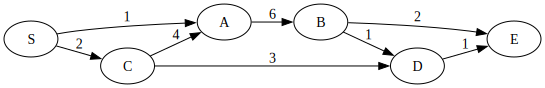

In [1]:
from graphviz import Digraph

nodes = set("SCABDE")
edges = {
    ("S", "A"): 1,
    ("S", "C"): 2,
    ("A", "B"): 6,
    ("C", "A"): 4,
    ("C", "D"): 3,
    ("B", "D"): 1,
    ("B", "E"): 2,
    ("D", "E"): 1
}

graph = Digraph(graph_attr={"rankdir": "LR"})

for node in nodes:
    graph.node(node, node)

for (u, v), cost in edges.items():
    graph.edge(u, v, str(cost))

graph

In [2]:
adj = {node: set() for node in nodes}
for u, v in edges:
    adj[v].add(u)

def topo(node, adj, topo_sorted, visited):
    if node in visited:
        return
    visited.add(node)
    
    for dest in adj[node]:
        topo(dest, adj, topo_sorted, visited)
    topo_sorted.append(node)

topo_sorted = []
visited = set()
topo("E", adj, topo_sorted, visited)

topo_sorted

['S', 'C', 'A', 'B', 'D', 'E']

In [3]:
dists = {"S": 0}

for node in topo_sorted:
    dists[node] = min([dists[prev] + edges[prev, node] for prev in adj[node]], default=0)

dists

{'S': 0, 'C': 2, 'A': 1, 'B': 7, 'D': 5, 'E': 6}

$D(a) = \min(D(b) + l(b,a): (b,a) \in E)$

Distance into node a is the minimum of the distance of prev nodes + the cost of the edge into a.

# 6.2: Longest subsequence

$L(j) = 1 + \max \{L(i) : (i, j) \in E\}$

The longest length to a node $L(j)$ is $1+$ the maximum length of all nodes that have an edge into $j$.  
The length of the longest subsequence is the maximimum length to a node.

In [4]:
L = [5, 2, 8, 6, 3, 6, 9, 7]
adj = {i: set(j for j in range(i) if L[j] < L[i]) for i in range(len(L))}
adj

{0: set(),
 1: set(),
 2: {0, 1},
 3: {0, 1},
 4: {1},
 5: {0, 1, 4},
 6: {0, 1, 2, 3, 4, 5},
 7: {0, 1, 3, 4, 5}}

In [5]:
lengths = [0 for _ in range(len(L))]

for i in range(len(lengths)):
    lengths[i] = 1 + max((lengths[j] for j in adj[i]), default=0)
lengths, max(lengths)

([1, 1, 2, 2, 2, 3, 4, 4], 4)

Dynamic programming: compute the max length to a node by relating it to the max length of nodes with edges into the node. Do this in 1 pass, from the base case up.

Dynamic programming is bottom-up. Recursion (with memoization) is top-down. Recursion without memoization is utter insanity.

In [6]:
lengths = [0 for _ in range(len(L))]
prevs = []

for i in range(len(lengths)):
    max_idx = max(adj[i], key=lambda idx: lengths[idx], default=None)
    lengths[i] = 1 + (0 if max_idx is None else lengths[max_idx])
    prevs.append(max_idx)

end_node_idx = max(range(len(lengths)), key=lambda idx: lengths[idx])
print(f"{lengths=}")
print(f"{end_node_idx=}")
print(f"{lengths[end_node_idx]=}")
print(f"{L=}")
print(f"{prevs=}")

idx_path = [end_node_idx]
while idx_path[-1] != None:
    idx_path.append(prevs[idx_path[-1]])
print(f"{idx_path=}")
num_path = list(reversed([L[i] for i in idx_path[:-1]]))
print(f"{num_path=}")

lengths=[1, 1, 2, 2, 2, 3, 4, 4]
end_node_idx=6
lengths[end_node_idx]=4
L=[5, 2, 8, 6, 3, 6, 9, 7]
prevs=[None, None, 0, 0, 1, 4, 5, 5]
idx_path=[6, 5, 4, 1, None]
num_path=[2, 3, 6, 9]


Keep track of index of the maximum length node we came from. Then at the end, backtrack to get the maximum subsequence path.

# 6.3: Edit distance

S-NOWY  
SUNN-Y  

Edit dist (cost) = 3

View 1: ops to change SNOWY -> SUNNY: insert U, replace N -> O, delete W  
View 2: alignment cost: add gap (+1), wrong letter (+1)

Goal: find edit dist b/t $x[1...m]$ and $y[1...n]$.

$E(i, j)$ = edit dist b/t $x[1...i]$ and $y[1...j]$

Goal: compute $E(m, n)$

We need to express $E(i, j)$ in terms of smaller subproblems.

Best alignment b/t $x[1...i]$ and $y[1...j]$:
* $x[i]$ and $\_\_$: $\text{cost} = 1 + E(i-1, j)$
* $\_\_$ and $y[j]$: $\text{cost} = 1 + E(i, j-1)$
* $x[i]$ and $y[i]$: $\text{cost} = (x[i] \neq y[j]) + E(i-1, j-1)$

$E(i, j) = min(1 + E(i-1, j), 1 + E(i, j-1), (x[i] \neq y[j]) + E(i-1, j-1))$

Solution to all subproblems $E(i, j)$ form 2d table.

![Edit dist table](images/edit_dist_table.png)

Order to subproblems: must have $E(i-1, j), E(i, j-1), E(i-1, j-1)$ solved before solving $E(i, j)$.  
This can be achieved moving in row-major or col-major order.

Base cases
* $E(0, j) = j$: dist b/t empty prefix of $x$ (empty str) and $y[1...j]$ is $j$
* $E(i, 0) = i$

In [7]:
x = "EXPONENTIAL"
y = "POLYNOMIAL"

m = len(x)
n = len(y)

E = [[0 for j in range(n+1)] for i in range(m+1)]
for i in range(m+1):
    for j in range(n+1):
        if i == 0:
            E[i][j] = j
        elif j == 0:
            E[i][j] = i
        else:
            E[i][j] = min(1 + E[i-1][j], 1 + E[i][j-1], (x[i-1]!=y[j-1]) + E[i-1][j-1])

print(f"      {", ".join(y)}")
for i, row in enumerate(E):
    print(f"{x[i-1] if i > 0 else ' '} {row}")
    
print(f"\nE(m, n): {E[m-1][n-1]}")  # E(m, n), the goal

      P, O, L, Y, N, O, M, I, A, L
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
E [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
X [2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10]
P [3, 2, 3, 3, 4, 5, 6, 7, 8, 9, 10]
O [4, 3, 2, 3, 4, 5, 5, 6, 7, 8, 9]
N [5, 4, 3, 3, 4, 4, 5, 6, 7, 8, 9]
E [6, 5, 4, 4, 4, 5, 5, 6, 7, 8, 9]
N [7, 6, 5, 5, 5, 4, 5, 6, 7, 8, 9]
T [8, 7, 6, 6, 6, 5, 5, 6, 7, 8, 9]
I [9, 8, 7, 7, 7, 6, 6, 6, 6, 7, 8]
A [10, 9, 8, 8, 8, 7, 7, 7, 7, 6, 7]
L [11, 10, 9, 8, 9, 8, 8, 8, 8, 7, 6]

E(m, n): 6


Fills in the table in row-major order.

$O(mn)$, since $O(mn)$ entries, and each entry takes $O(1)$ time to fill in.

Dynamic programs have underlying DAG (Directed Acyclic Graph) structures. Each node is a subproblem, and edges are dependencies.

Setting all edges to length 1, except for edges going into $(i, j)$ if ($x[i] = y[j]$, the solution is the distance b/t $(0, 0)$ and $(m, n)$. Each step down is a DELETE on x, each step right is an INSERT on y, and each diagonal step is a CHANGE/KEEP on y.

Input $x_1, ..., x_n$, and subproblem is $x_1, ..., x_i$: $O(n)$ subproblems

Inputs $x_1, ..., x_n$ and $y_1, ..., y_n$, and subproblem is $x_1, ..., x_i$ and $y_1, ..., y_i$: $O(nm)$ subproblems

Input $x_1, ..., x_n$, and subproblem is $x_i, ..., x_j$: $O(n^2)$ subproblems

Input rooted tree, subproblem rooted subtree: $O(n)$ subproblems

## Of mice and men
* DNA encoded by 3 billion chars over $\{A, C, G, T\}$
* DNA of people vary by 0.1%, 3 million base positions
* DNA broken down into smaller gene units
* Finding close gene matches gives insight into function
* BLAST algorithm for computational biology

# 6.4: Knapsack

Robber can carry maximum weight of $W$ pounds.

$n$ items w/ weights $w_1...w_n$ and values $v_1...v_n$

What is the most valuable combo of items he can pick?

$W = 10$


| Item | Weight | Value |
|------|--------|-------|
|  1   |   6    |  30   |
|  2   |   3    |  14   |
|  3   |   4    |  16   |
|  4   |   2    |  9    |

w/ repetitions (infinite # of each item): optimal = item1 + 2 * item2, $48

w/out repetitions (each item once): optimal = item1 + item2, $46

In [8]:
items = [1, 2, 3, 4]
weights = [6, 3, 4, 2]
values = [30, 14, 16, 9]

W = 10

## With repetition

### My solution
Goal: compute $V(0)$, the maximum value the robber can get when he has no weight in the bag, $W=0$.

Break up into smaller subproblems: $V(0) = \max\{30 + V(6), 14 + V(3), 16 + V(4), 9 + V(2)\}$

Terminates at $V(x) = 0: x \ge W$

Dependency: we iterate backwards from $W$ since $V(0)$ depends on values of $V$ after $0$.

DP Algo: $V(w) = \max\{ V(w+w_i) + v_i : i \in [1,n] \}$

In [9]:
max_vals = [0 for _ in range(W+1)]

for weight in reversed(range(W)):
    max_vals[weight] = max(0 if weight+w > W else max_vals[weight+w] + v for (w,v) in zip(weights,values))

print(f"{max_vals=}")

max_vals=[48, 44, 39, 32, 30, 23, 18, 14, 9, 0, 0]


In [10]:
max_vals = [0 for _ in range(W+1)]
best_items = [0 for _ in range(W+1)]

for weight in reversed(range(W)):
    poss_vals = [0 if weight+w > W else max_vals[weight+w] + v for (w,v) in zip(weights,values)]
    best_item = max(range(len(poss_vals)), key=lambda idx: poss_vals[idx])

    max_vals[weight] = poss_vals[best_item]
    best_items[weight] = best_item

print(f"{max_vals=}")
print(f"{best_items=}")

item_path = []
weight = 0
while weight < W:
    item_path.append(best_items[weight] + 1) # +1 because best_items are inds.
    weight += weights[best_items[weight]]

print(f"{item_path=}")

max_vals=[48, 44, 39, 32, 30, 23, 18, 14, 9, 0, 0]
best_items=[0, 0, 0, 1, 0, 1, 3, 1, 3, 0, 0]
item_path=[1, 4, 4]


### Textbook solution:

$V(w) = \text{max value achievable w/ knapsack of weight } w$

$V(w) = \max \{ V(w-w_i) + v_i: i \in [1,n] \}$

Textbook solution is better since iterations can be extended.

In [11]:
max_vals = [0 for _ in range(W+1)]

for weight in range(W+1):
    max_vals[weight] = max(0 if weight-w < 0 else max_vals[weight-w] + v for (w,v) in zip(weights,values))

max_vals

[0, 0, 9, 14, 18, 23, 30, 32, 39, 44, 48]

Each entry takes $O(n)$ to compute, so total running time is $O(Wn)$

Looking at the underlying DAG, where nodes are the weights, edges are items you can choose, and edge lengths are costs, the optimal solution is the longest path through the DAG.

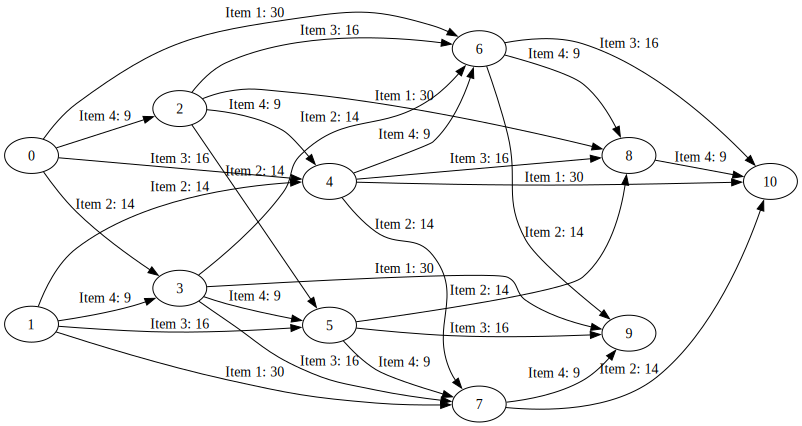

In [12]:
# Underlying DAG.
graph = Digraph(graph_attr={"rankdir":"LR"})

for w in range(W+1):
    graph.node(str(w), str(w))

    for i, (wi, v) in enumerate(zip(weights, values)):
        if w+wi <= W:
            graph.edge(str(w), str(w+wi), label=f"Item {i+1}: {v}")

graph

## Knapsack w/out repetition
Repetitions are no longer allowed. Knowing $V(w-w_i)$ doesn't help if item $i$ was already used.

Let $V(w,i)$ be the maximum value attainable with weight $w$ and items $1...i$.

Goal: $V(W,n)$  
Subproblem: $V(w,i)$

$V(w,i) = \max \{ V(w-w_i, i-1) + v_i, V(w, i-1) \}$  
We either need item $i$ to achieve the maximum value: $V(w-w_i, i-1) + v_i$, or we don't: $V(w,i-1)$

Fill in 2D table: $(W+1, n+1)$

Base cases: $V(0, i) = 0$ and $V(W, 0) = 0$

$O(1)$ to fill in a single entry, $O(nW)$ entries, so same $O(nW)$ runtime.

In [13]:
import numpy as np

n = len(items)
V = np.zeros((W+1, n+1))

for w in range(1,W+1):
    for i in range(1, n+1):
        if weights[i-1] > w:
            V[w,i] = V[w,i-1]
        else:
            V[w,i] = max(V[w-weights[i-1],i-1] + values[i-1], V[w,i-1])

print(V)
print(V[-1,-1])

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  9.]
 [ 0.  0. 14. 14. 14.]
 [ 0.  0. 14. 16. 16.]
 [ 0.  0. 14. 16. 23.]
 [ 0. 30. 30. 30. 30.]
 [ 0. 30. 30. 30. 30.]
 [ 0. 30. 30. 30. 39.]
 [ 0. 30. 44. 44. 44.]
 [ 0. 30. 44. 46. 46.]]
46.0


## Memoization
DP: write recursive formula, then sovle smallest subproblem -> largest subproblem  
Memoization: use recursion, but storing outputs in a hash table to avoid duplicate computation

DP advantage: no recursive call overhead  
Memoization advantage: only calculate what you need (DP fills in entire table of solution vals).

In [14]:
def knapsack(w, cache=None):
    if cache is None:
        cache = {}
    
    if w not in cache:
        cache[w] = max(0 if w-wi < 0 else knapsack(w-wi, cache) + v for wi, v in zip(weights, values))
    return cache[w]

knapsack(10)

48

# 6.5: Chain Matrix Multiplication
Multiply matricies $A \times B \times C \times D$ of dims $(50,20), (20,1), (1,10), (10,100)$.

Matrix multiplication is associative: $(A \times B) \times C$ = $A \times (B \times C)$  
Matmul of $(m,n) \times (n,p)$ takes $O(mnp)$ multiplications

$A \times ((B \times C) \times D) = 120200$ multiplies.  
$(A \times B) \times (C \times D) = 7000$ multiplies.  

Goal: find optimal order of computing $A_1 \times A_2 \times ... \times A_n$, where dimensions are $(m_0, m_1), (m_1, m_2), ..., (m_{n-1}, m_n)$

Binary tree, where leaves are $A_i$, the root is the final product, and other nodes are intermediate products.  
$n$ leaves, so possible orderings is exponential in $n$.

An optimal tree has optimal subtrees.  

Let $C(i,j)$ be the minimum cost of multiplying $(A_1 \times ... \times A_i) \times A_j$  
$C(i, j) = \min \{ C(i,k) + C(k+1,j) + (m_{i-1} \times m_k \times m_j) : k \in [i,j] \}$

We split up the cost of the subtree $C(i,j)$ into the cost of the left subtree $C(i,k)$ and the cost of the right subtree $C(k+1,j)$, and add the cost of multiplying the matricies from the left and right subtrees $m_{i-1} \times m_k \times m_j$. We iterate over all $i \le k < j$ to find the mimimum cost.

In [15]:
dims = [50, 20, 1, 10, 100]
n = len(dims) - 1

C = np.zeros((n,n))

for i in range(1,n-1):
    for j in range(i+1,n):
        C[i,j] = min(C[i,k] + C[k+1,j] + (dims[i-1]*dims[k]*dims[j]) for k in range(i,j))

print(C)
print(C[1,n-1])

[[   0.    0.    0.    0.]
 [   0.    0. 1000. 1500.]
 [   0.    0.    0.  200.]
 [   0.    0.    0.    0.]]
1500.0


# 6.6: Shortest paths


## Shortest reliable path

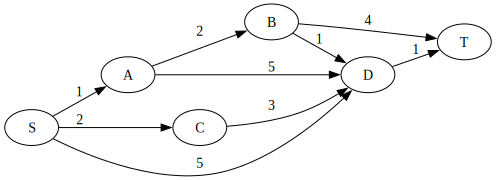

In [16]:
graph = Digraph(graph_attr={"rankdir":"LR"})

nodes = list("SACBDT")
edges = {
    ("S","A"): 1,
    ("S","C"): 2,
    ("S","D"): 5,
    ("A","B"): 2,
    ("A","D"): 5,
    ("C","D"): 3,
    ("B","D"): 1,
    ("B","T"): 4,
    ("D","T"): 1
}

adj = {node:set() for node in nodes}
for u,v in edges:
    adj[v].add(u)

for node in nodes:
    graph.node(node, node)

for (u,v), cost in edges.items():
    graph.edge(u,v,str(cost))

graph

Given graph $G$, find the shortest path from node $s$ to node $T$ that uses at most $k$ edges.

Let $D(v,i)$ be the length of the shortest path from $s$ to $v$ using $i$ edges.  
$D(v,0) = \infty$, $D(s,.) = 0$

$D(v,i) = min \{ D(u,i-1) + l(u,v) : (u,v) \in E \}$

Dist from $s$ to $v$ using $i$ edges is the minimum dist of all nodes that go into $v$ and used $i-1$ edges + edge length. 

In [17]:
n = len(nodes)
k = 3

node_i = {n:i for i,n in enumerate(nodes)}

D = np.zeros((n,k))

for v in range(n):
    for i in range(k):
        if v == node_i["S"]:
            D[v,i] = 0
        elif i == 0:
            D[v,i] = float("inf")
        else:
            D[v,i] = min((D[node_i[u],i-1] + edges[(u,nodes[v])] for u in adj[nodes[v]]))

print(D)
print(D[n-1,k-1])

[[ 0.  0.  0.]
 [inf  1.  1.]
 [inf  2.  2.]
 [inf inf  3.]
 [inf  5.  5.]
 [inf inf  6.]]
6.0


## All pairs shortest paths
We want to find the shortest path b/t all pairs of vertices.

Naive approach: run Bellman-Ford $O(|V||E|)$ for each starting vertex: $O(|V|^2 |E|)$

Floyd-Warshall algorithm: $O(|V|^3)$.
* Vertices $V \{1, 2, ..., n\}$
* $\text{dist}(i,j,k)$ is the length of the shortest path from $i$ to $j$ using only nodes $\{1,2,...,k\}$ as intermediates
* When we expand the intermediate set to include extra node $k$, re-examining all pairs $(i,j)$, $\text{dist}(i,j,k) = min(\text{dist}(i,j,k-1), \text{dist}(i,k,k-1) + \text{dist}(k,j,k-1))$

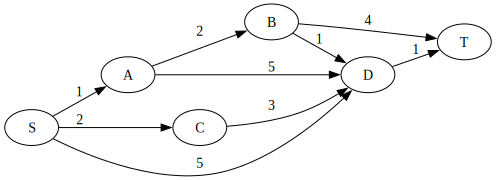

In [18]:
graph

In [19]:
dists = np.full((n,n,n), float("inf"))

for (u,v), l in edges.items():
    dists[node_i[u], node_i[v],0] = l

for k in range(1,n):
    for i in range(0,n):
        for j in range(0,n):
            dists[i,j,k] = min(dists[i,j,k-1], dists[i,k,k-1] + dists[k,j,k-1])

print(nodes)
dists[:,:,-1]

['S', 'A', 'C', 'B', 'D', 'T']


array([[inf,  1.,  2.,  3.,  4.,  5.],
       [inf, inf, inf,  2.,  3.,  4.],
       [inf, inf, inf, inf,  3.,  4.],
       [inf, inf, inf, inf,  1.,  2.],
       [inf, inf, inf, inf, inf,  1.],
       [inf, inf, inf, inf, inf, inf]])